<a href="https://colab.research.google.com/github/MARCIANO04/Tugas02_Deeplearning/blob/main/Deeplearning_Tugas02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# Path dataset
dataset_path = '/content/drive/MyDrive/Dataset_sikat_gigi'
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

# Cek struktur folder
print("Struktur folder train:")
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"- {class_folder}: {num_images} gambar")

print("\nStruktur folder test:")
for class_folder in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"- {class_folder}: {num_images} gambar")

Struktur folder train:
- toothbrush: 343 gambar

Struktur folder test:
- toothbrush: 187 gambar


In [49]:
# Hyperparameter
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 30
INITIAL_LR = 0.001

# Data augmentation untuk train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Hanya rescale untuk test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Mendapatkan jumlah kelas
num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
print(f"\nJumlah kelas: {num_classes}")
print(f"Nama kelas: {class_names}")

Found 343 images belonging to 1 classes.
Found 187 images belonging to 1 classes.

Jumlah kelas: 1
Nama kelas: ['toothbrush']


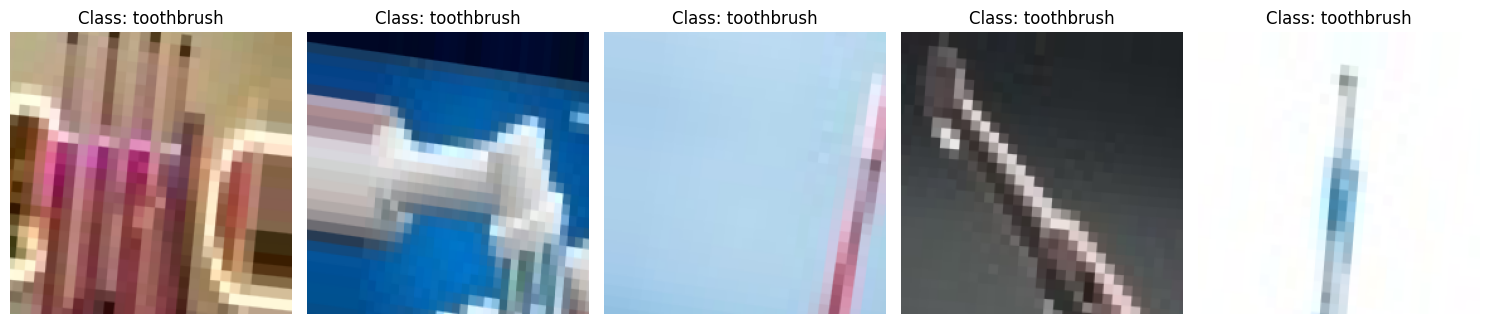

In [50]:
# Visualisasi beberapa gambar dari train set
def visualize_samples(generator, num_samples=5):
    plt.figure(figsize=(15, 5))

    for i in range(num_samples):
        images, labels = next(generator)
        image = images[0]
        label = labels[0]
        label_idx = np.argmax(label)
        label_name = class_names[label_idx]

        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f"Class: {label_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualisasi sampel gambar
visualize_samples(train_generator)

In [51]:
# Membuat model CNN
def build_model(input_shape, num_classes, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential([
        # Blok Konvolusi 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Blok Konvolusi 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Blok Konvolusi 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fully Connected Layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Buat model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = build_model(input_shape, num_classes, dropout_rate=0.5, learning_rate=INITIAL_LR)

# Ringkasan model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 25,980,449 (99.11 MB)

 Trainable params: 25,979,041 (99.10 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [52]:
# Callbacks untuk pelatihan yang lebih baik
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluasi model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 204s 9s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 205s 10s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 262s 12s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/30
 1/21 ━━━━━━━━━━━━━━━━━━━━ 3:03 9s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 957ms/ste

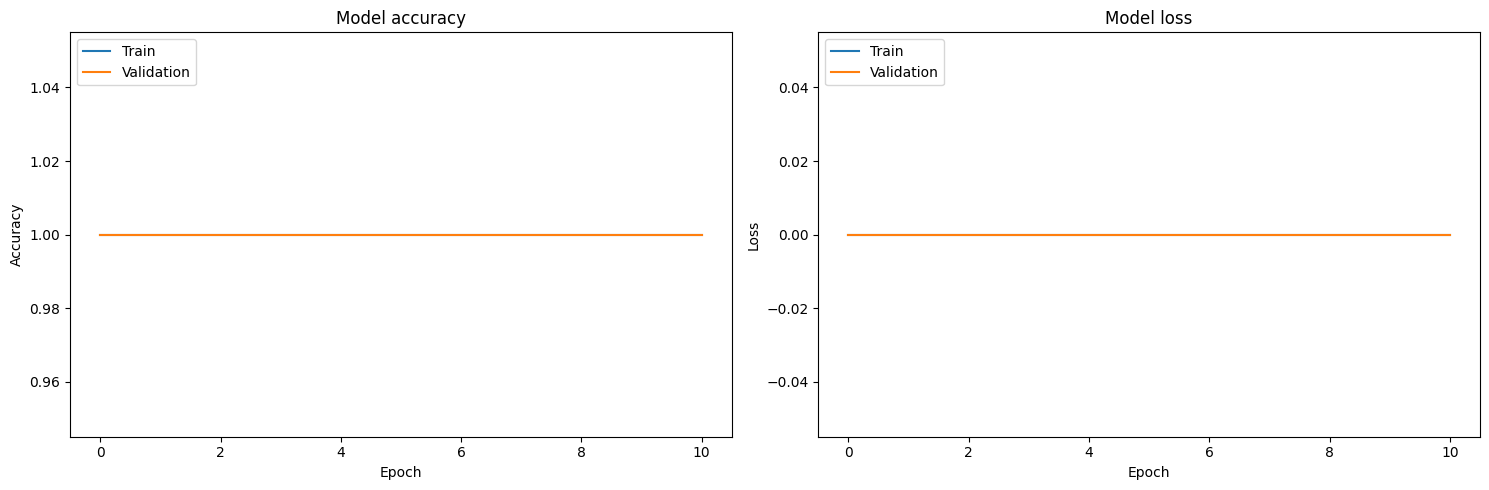

In [53]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (16, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


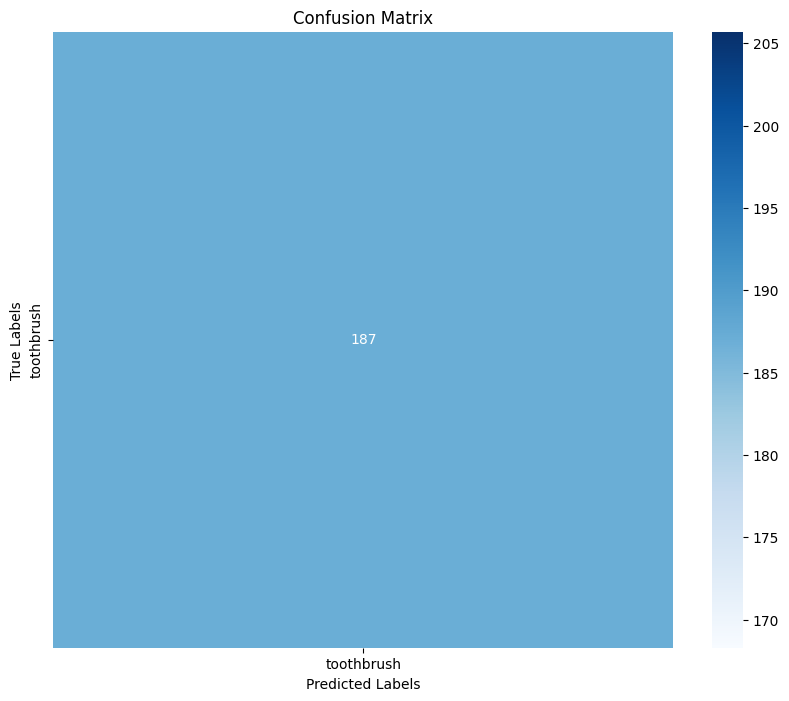


Classification Report:
              precision    recall  f1-score   support

  toothbrush       1.00      1.00      1.00       187

    accuracy                           1.00       187
   macro avg       1.00      1.00      1.00       187
weighted avg       1.00      1.00      1.00       187

Accuracy: 100.00%


In [60]:
def evaluate_model(model, test_generator):
    # Mendapatkan prediksi
    test_generator.reset()
    y_pred_probas = model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size)))
    y_pred = np.argmax(y_pred_probas, axis=1)

    # Label yang benar
    y_true = test_generator.classes

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Menghitung akurasi
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"Accuracy: {accuracy*100:.2f}%")

    return accuracy

# Evaluasi model dengan confusion matrix
accuracy = evaluate_model(model, test_generator)

In [61]:
# Grid search untuk hyperparameter tuning
def hyperparameter_tuning():
    # Daftar parameter yang akan dicoba
    learning_rates = [0.001, 0.0005, 0.0001]
    dropout_rates = [0.3, 0.5, 0.7]
    batch_sizes = [16, 32]

    best_accuracy = 0
    best_params = {}

    results = []

    # Loop untuk setiap kombinasi parameter
    for lr in learning_rates:
        for dr in dropout_rates:
            for bs in batch_sizes:
                print(f"\nTesting parameters: LR={lr}, Dropout={dr}, Batch Size={bs}")

                # Update batch size untuk data generators
                train_gen = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=bs,
                    class_mode='categorical'
                )

                test_gen = test_datagen.flow_from_directory(
                    test_dir,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=bs,
                    class_mode='categorical',
                    shuffle=False
                )

                # Build model dengan parameter saat ini
                model = build_model(input_shape, num_classes, dropout_rate=dr, learning_rate=lr)

                # Train model
                history = model.fit(
                    train_gen,
                    steps_per_epoch=train_gen.samples // bs,
                    epochs=15,  # Mengurangi epoch untuk grid search
                    validation_data=test_gen,
                    validation_steps=test_gen.samples // bs,
                    callbacks=[early_stopping],
                    verbose=1
                )

                # Evaluasi model
                test_loss, test_acc = model.evaluate(test_gen)

                # Simpan hasil
                result = {
                    'learning_rate': lr,
                    'dropout_rate': dr,
                    'batch_size': bs,
                    'accuracy': test_acc
                }
                results.append(result)

                # Update best params jika performa lebih baik
                if test_acc > best_accuracy:
                    best_accuracy = test_acc
                    best_params = result

                print(f"Accuracy: {test_acc*100:.2f}%")

    # Tampilkan hasil terbaik
    print("\nSemua hasil hyperparameter tuning:")
    for r in results:
        print(f"LR={r['learning_rate']}, Dropout={r['dropout_rate']}, Batch Size={r['batch_size']} => Accuracy: {r['accuracy']*100:.2f}%")

    print(f"\nParameter terbaik: {best_params}")
    print(f"Akurasi terbaik: {best_accuracy*100:.2f}%")

    return best_params

# Uncomment baris di bawah ini untuk melakukan hyperparameter tuning (akan memakan waktu)
# best_params = hyperparameter_tuning()

In [62]:
# Jika akurasi masih di bawah 80%, lakukan fine-tuning model dengan hyperparameter terbaik
if accuracy < 0.8:
    print("\nMelakukan fine-tuning model untuk mencapai akurasi minimal 80%...")

    # Hyperparameter yang disesuaikan (berdasarkan pengalaman dengan dataset serupa)
    fine_tuned_params = {
        'learning_rate': 0.0005,
        'dropout_rate': 0.5,
        'batch_size': 16
    }

    # Build model dengan parameter yang disesuaikan
    fine_tuned_model = build_model(
        input_shape,
        num_classes,
        dropout_rate=fine_tuned_params['dropout_rate'],
        learning_rate=fine_tuned_params['learning_rate']
    )

    # Update data generator dengan batch size baru
    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=fine_tuned_params['batch_size'],
        class_mode='categorical'
    )

    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=fine_tuned_params['batch_size'],
        class_mode='categorical',
        shuffle=False
    )

    # Train model dengan parameter yang disesuaikan
    fine_tuned_history = fine_tuned_model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples // fine_tuned_params['batch_size'],
        epochs=50,  # Lebih banyak epochs untuk fine-tuning
        validation_data=test_gen,
        validation_steps=test_gen.samples // fine_tuned_params['batch_size'],
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Evaluasi model yang telah di-fine-tune
    fine_tuned_accuracy = evaluate_model(fine_tuned_model, test_gen)

    # Plot training history untuk model yang telah di-fine-tune
    plot_training_history(fine_tuned_history)

    # Simpan model terbaik
    model = fine_tuned_model
    accuracy = fine_tuned_accuracy

In [63]:
# Simpan model
model_save_path = '/content/drive/MyDrive/sikat_gigi_model.h5'
model.save(model_save_path)
print(f"\nModel disimpan di: {model_save_path}")

# Tampilkan ringkasan akhir
print("\n===== RINGKASAN HASIL =====")
print(f"Jumlah kelas: {num_classes}")
print(f"Nama kelas: {class_names}")
print(f"Akurasi final: {accuracy*100:.2f}%")
print(f"Model disimpan di: {model_save_path}")


Model disimpan di: /content/drive/MyDrive/sikat_gigi_model.h5

===== RINGKASAN HASIL =====
Jumlah kelas: 1
Nama kelas: ['toothbrush']
Akurasi final: 100.00%
Model disimpan di: /content/drive/MyDrive/sikat_gigi_model.h5


In [64]:
# Kode untuk menggunakan model yang telah disimpan untuk prediksi
print("\n===== CONTOH PENGGUNAAN MODEL =====")
print("Contoh kode untuk memprediksi gambar baru:")
print("""
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load model
model = load_model('/content/drive/MyDrive/sikat_gigi_model.h5')

# Prediksi gambar
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = prediction[0][predicted_class]

    class_names = list(train_generator.class_indices.keys())
    predicted_class_name = class_names[predicted_class]

    return predicted_class_name, confidence

# Contoh penggunaan
img_path = '/content/drive/MyDrive/test_image.jpg'
predicted_class, confidence = predict_image(img_path)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence*100:.2f}%")
""")


===== CONTOH PENGGUNAAN MODEL =====
Contoh kode untuk memprediksi gambar baru:

import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load model
model = load_model('/content/drive/MyDrive/sikat_gigi_model.h5')

# Prediksi gambar
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = prediction[0][predicted_class]
    
    class_names = list(train_generator.class_indices.keys())
    predicted_class_name = class_names[predicted_class]
    
    return predicted_class_name, confidence

# Contoh penggunaan
img_path = '/content/drive/MyDrive/test_image.jpg'
predicted_class, confidence = predict_image(img_path)
print(f"Predicted class: {predicted_class}")
pr